In [ ]:
import numpy as np 
import numpy.random as rand
import matplotlib.pyplot as plt
import torchvision.datasets
from PIL import Image

# Forward Process

In [ ]:
T=500
IMG_SIZE=128

betas=np.linspace(start=0.0001, stop=0.02, num=T)
alphas=1-betas
alphas_cumprod=np.cumprod(alphas)
sqrt_alphas_cumprod=np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod=np.sqrt(1-alphas_cumprod)

def forward_diffusion_process(x0, t):
    """
    Get noisy image of x0 obtained after t timesteps
    """
    noise=rand.standard_normal(size=x0.shape)
    return sqrt_alphas_cumprod[t]*x0+sqrt_one_minus_alphas_cumprod[t]*noise, noise

# Reduces image resolution
def transform_img(image : Image):
    """
    Horizontal flips given image with random probability
    and scales it to values between -1 and 1.
    """
    image.thumbnail((IMG_SIZE,IMG_SIZE))
    prob=rand.random()

    if prob>0.5:
        image=image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    img_arr=np.array(image).astype(np.float32)

    #Scale between -1 and 1
    img_arr=2*img_arr/255-1

    return img_arr

def reverse_transform_img(img_arr):
    """
    Given an image array scales it back to valid RGB
    """
    img_arr=(img_arr+1)/2
    img_arr*=255
    img_arr=np.array(img_arr).astype(np.uint8)
    return img_arr


### Example

In [ ]:
im=Image.open("test_img.jpg")
img=transform_img(im)

plt.figure(figsize=(20,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for t in range(0, T, stepsize):
    plt.subplot(1, num_images+1, int(t/stepsize) + 1)
    noisy_img, noise = forward_diffusion_process(img, t)
    noisy_img=reverse_transform_img(noisy_img)
    plt.imshow(noisy_img)

## Data Loading

In [12]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    mnist = torchvision.datasets.MNIST(root=".", download=True,
                                         transform=data_transform)
    return mnist

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image), cmap='gray')

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

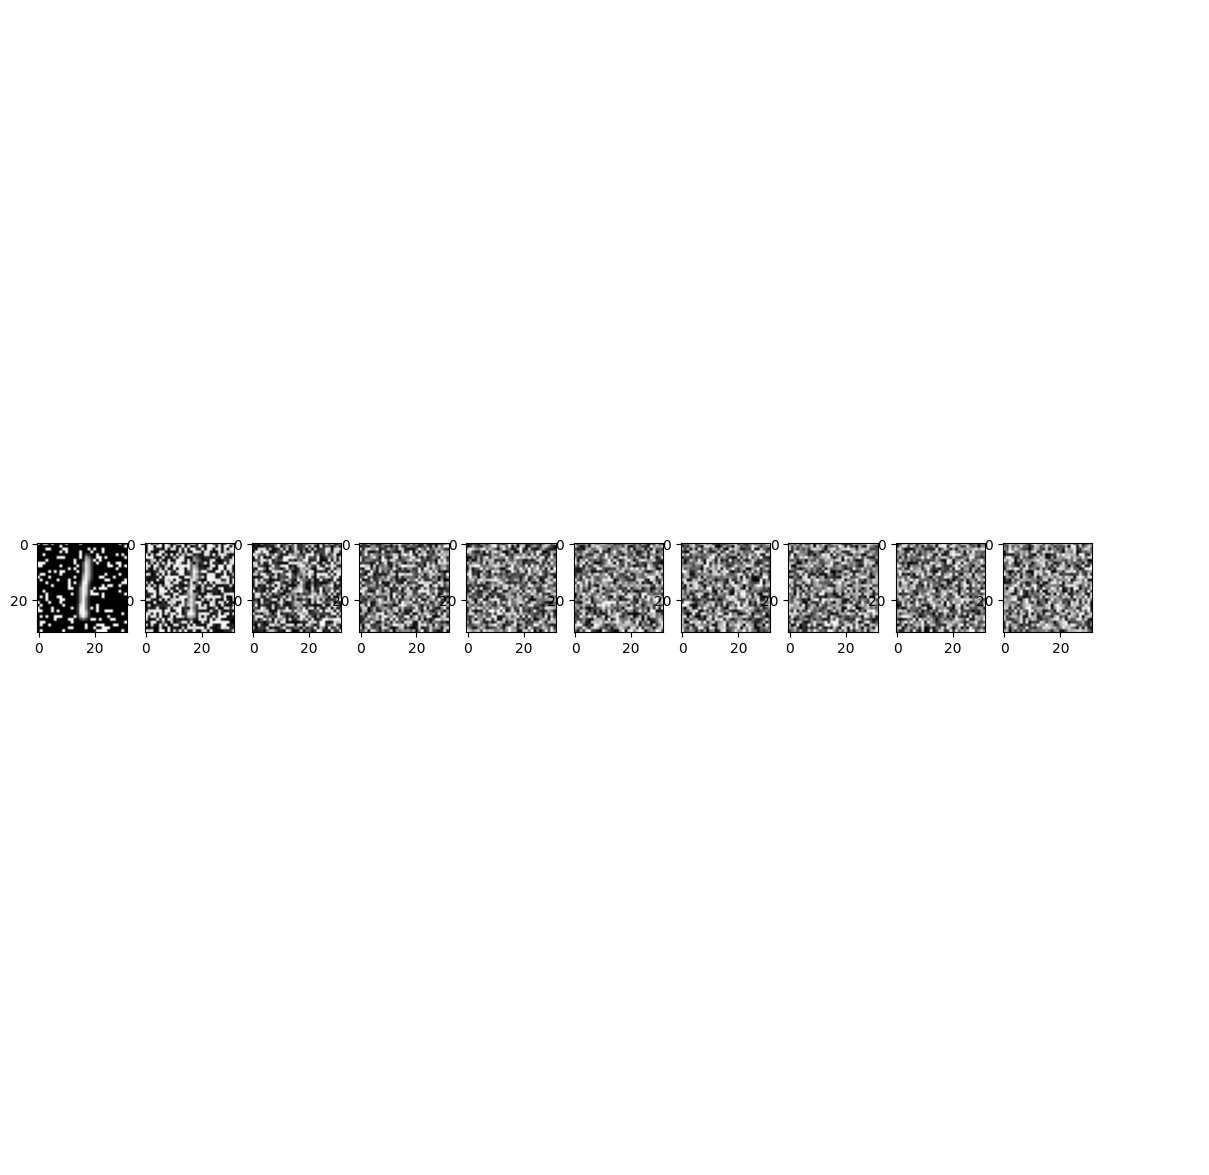

In [13]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_process(image, t)
    show_tensor_image(img)